In [ ]:
import pandas as pd
from sklearn.cluster import KMeans


In [ ]:
file_path = "compras_completo_limpio.csv"
df = pd.read_csv(file_path)

In [48]:
# Seleccionar las columnas relevantes para el clustering
columnas_clustering = ["precio",'piscina', 'aire_acondicionado', 'superficie', 'antiguedad', 'habitaciones', 'baños']

# Filtrar el DataFrame con las columnas seleccionadas
df_clustering = df[columnas_clustering].copy()

df_clustering['piscina'] = df_clustering['piscina'].map({'Si': 1, 'No': 0})
df_clustering['aire_acondicionado'] = df_clustering['aire_acondicionado'].map({'Si': 1, 'No': 0})

# Convertir la columna 'antiguedad' a valores numéricos
antiguedad_map = {
    'Menos de 5 años': 2,
    'Entre 5 y 10 años': 7,
    'Entre 10 y 20 años': 15,
    'Entre 20 y 30 años': 25,
    'Entre 30 y 50 años': 40,
    'Más de 50 años': 60
}
df_clustering['antiguedad'] = df_clustering['antiguedad'].map(antiguedad_map)

In [50]:
# Rellenar valores nulos con la media de cada columna
df_clustering.fillna(df_clustering.mean(numeric_only=True), inplace=True)


In [52]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_clustering['Cluster'] = kmeans.fit_predict(df_clustering)

In [ ]:
df_clustering.to_csv("dataset_clustering.csv", index=False)

In [ ]:
file_path = "dataset_clustering.csv"
df2 = pd.read_csv(file_path)

In [ ]:
df2

In [ ]:
df2["Cluster"].value_counts()

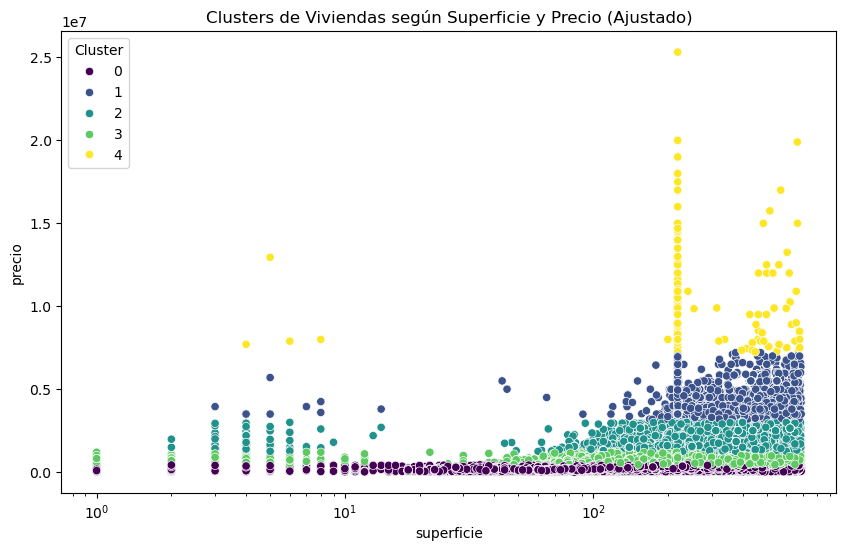

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar valores extremos para mejor visualización
df_filtrado = df_clustering[df_clustering["superficie"] < df_clustering["superficie"].quantile(0.99)]

# Graficar sin valores extremos
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_filtrado, x="superficie", y="precio", hue="Cluster", palette="viridis")

plt.xscale("log")  # Aplicar escala logarítmica
plt.title("Clusters de Viviendas según Superficie y Precio (Ajustado)")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Seleccionar las variables (usamos el cluster como una feature)
X = df2.drop(columns=["precio"])  # Variables predictoras (incluye "Cluster")
y = df2["precio"]  # Variable objetivo (precio de la vivienda)

# Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Crear y entrenar el modelo
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# Evaluar el modelo
score = modelo.score(X_test, y_test)
print(f"Precisión del modelo: {score:.2f}")

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir el rango de hiperparámetros
param_grid = {
    "n_estimators": [50, 100, 200],  # Número de árboles
    "max_depth": [10, 20, None],  # Profundidad del árbol
    "min_samples_split": [2, 5, 10]  # Mínimo de muestras para dividir nodos
}

# Grid Search con validación cruzada
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar con los mejores hiperparámetros
best_model = grid_search.best_estimator_
score_best = best_model.score(X_test, y_test)
print(f"Precisión del modelo optimizado: {score_best:.2f}")

In [ ]:
df["latitud"] = df["coordenadas"].str.split(",").str[0].str.strip().astype(float, errors='ignore')
df["longitud"] = df["coordenadas"].str.split(",").str[1].str.strip().astype(float, errors='ignore')

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Copia del dataframe para procesar
df_clean = df.copy()

# Seleccionar variables relevantes para clustering
features = ["precio", "precio_m2", "antiguedad", "conservacion", "coordenadas"]

# Eliminar filas con datos faltantes en las columnas seleccionadas
df_clean = df_clean.dropna(subset=["precio", "precio_m2"])

# Convertir 'antiguedad' en valores numéricos
antiguedad_map = {
    "Menos de 5 años": 2.5, "Entre 5 y 10 años": 7.5, "Entre 10 y 20 años": 15,
    "Entre 20 y 30 años": 25, "Más de 30 años": 35
}
df_clean["antiguedad"] = df_clean["antiguedad"].map(antiguedad_map).fillna(20)  # Rellenar NaN con un valor intermedio

# Convertir 'conservacion' en valores numéricos
conservacion_map = {
    "A estrenar": 1, "En buen estado": 2, "A reformar": 3
}
df_clean["conservacion"] = df_clean["conservacion"].map(conservacion_map).fillna(2)  # Rellenar con 'En buen estado'

# Procesar coordenadas (convertir de texto a números separados)
df_clean[["latitud", "longitud"]] = df_clean["coordenadas"].str.split(",", expand=True).astype(float)
features.extend(["latitud", "longitud"])

# Normalizar los datos para K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[["precio", "precio_m2", "antiguedad", "conservacion", "latitud", "longitud"]])

# Determinar el número óptimo de clusters usando el método del codo
inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia")
plt.title("Método del Codo para K-Means")
plt.grid()
plt.show()